In [2]:
!pip install contractions
!pip install nltk
!pip install transformers

In [3]:
import random
import re
import string

import contractions

import nltk
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from transformers import TFRobertaModel, RobertaTokenizerFast
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint


from tabulate import tabulate
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


In [41]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [42]:
from google.colab import drive

In [43]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test (2).txt
Saving train.txt to train (1).txt
Saving val.txt to val (1).txt


In [5]:


train_df = pd.read_csv( 'dataset/train.txt', sep=';', names=['content', 'sentiment'], header=0)
test_df = pd.read_csv( 'dataset/test.txt', sep=';', names=['content', 'sentiment'], header=0)
valid_df = pd.read_csv( 'dataset/val.txt', sep=';', names=['content', 'sentiment'], header=0)
data = pd.concat([train_df, test_df, valid_df], axis=0)


In [6]:
df = data.copy()
df['content_len'] = df['content'].apply(len)
df.head()

,content,sentiment,content_len
0,i can go from feeling so hopeless to so damned...,sadness,108
1,im grabbing a minute to post i feel greedy wrong,anger,48
2,i am ever feeling nostalgic about the fireplac...,love,92
3,i am feeling grouchy,anger,20
4,ive been feeling a little burdened lately wasn...,sadness,65


#### Distribution of tweet length by emotion class

Notice a second spike on the left plot at ~140 characters in length. A while back the tweets were limited to 140 chars, and thus we see that people were trying to fit their tweets within that limit.


# Data Pre-processing

### Cleaning and Lemmatization

In [12]:
df_clean = data.copy()

In [13]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def expand_contractions(text):
    '''
    Function replaces abbreviations with full word versions
    '''
    return contractions.fix(text)

def clean_content(text):

    text = expand_contractions(text)
    # remove twitter handles
    clean_text = re.sub(r'@\w+\s?', '', text)
    
    # convert to lowercase
    clean_text = clean_text.lower()
    
    # remove links http:// or https://
    clean_text = re.sub(r'https?:\/\/\S+', '', clean_text)
    
    # remove links beginning with www. and ending with .com
    clean_text = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', clean_text)
    
    # remove html reference characters
    clean_text = re.sub(r'&[a-z]+;', '', clean_text)
    
    # remove non-letter characters besides spaces "/", ";" "[", "]" "=", "#"
    clean_text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', clean_text)           
    clean_text = clean_text.split()
    
    # remove stop words
    clean_lst = []
    for word in clean_text:
          if word not in stop_words:
            clean_lst.append(word)
    

    lemmatized_words = []
    for word in clean_lst:
      '''
      # Assign a tag to each part of speech
      tag = pos_tag([word])[0][1][0].upper()
      tag_dict = {'J': wordnet.ADJ,
                  'N': wordnet.NOUN,
                  'V': wordnet.VERB,
                  'R': wordnet.ADV}
      pos = tag_dict.get(tag, wordnet.NOUN)
      
      # lemmatization
      lemmatized_word = WordNetLemmatizer().lemmatize(word, pos)
      '''
      lemmatized_word = WordNetLemmatizer().lemmatize(word)
      lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

df_clean['content'] = df_clean['content'].apply(lambda x :  clean_content(x))

# delete duplicates
df_clean.drop_duplicates(subset='content', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# delete small sentence
df_clean = df_clean.loc[df_clean['content'].apply(lambda x: len(x) >= 3)]

# splitting into tokens, features of the structure of the text used in Twitter
df_clean['content'] = df_clean['content'].apply(TweetTokenizer().tokenize)

# remove punctuation marks
PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    return [w for w in word_list if w not in PUNCUATION_LIST]

df_clean['content'] = df_clean['content'].apply(remove_punctuation)
df_clean['content'] = df_clean['content'].apply(lambda x: ' '.join(x))


df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19778 entries, 0 to 19777
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    19778 non-null  object
 1   sentiment  19778 non-null  object
dtypes: object(2)
memory usage: 463.5+ KB


,content,sentiment
0,go feeling hopeless damned hopeful around some...,sadness
1,grabbing minute post feel greedy wrong,anger
2,ever feeling nostalgic fireplace know still pr...,love
3,feeling grouchy,anger
4,feeling little burdened lately sure,sadness


## Training Process

In [14]:
# splitting the dataframe into training, validation, and testing data.

X =df_clean['content'].values
y =df_clean['sentiment'].values

X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_valid, y_train, y_valid = train_test_split(X_train0, y_train0, test_size=0.25, random_state=42)



print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')


X_train: 11866; X_test: 3956; X_valid: 3956
y_train: 11866; y_test: 3956; y_valid: 3956


In [49]:
y_train = OneHotEncoder().fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = OneHotEncoder().fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = OneHotEncoder().fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [11]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

In [52]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

72

In [53]:
MAX_LEN=128

In [54]:
def tokenize_roberta(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_inputs, train_masks = tokenize_roberta(X_train, MAX_LEN)
val_inputs, val_masks = tokenize_roberta(X_valid, MAX_LEN)
test_inputs, test_masks = tokenize_roberta(X_test, MAX_LEN)

In [56]:
def create_model(bert_model, max_len=MAX_LEN):
    inputs = Input(shape=(max_len,), dtype='int32')
    masks = Input(shape=(max_len,), dtype='int32')

    bert_output = bert_model([inputs, masks])[1]

    dense_1 = Dense(128, activation='relu')(bert_output)
    dropout_1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(64, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.5)(dense_2)

    output = Dense(6, activation='softmax')(dropout_2)

    model = Model(inputs=[inputs, masks], outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-7),
                  loss=CategoricalCrossentropy(),
                  metrics=CategoricalAccuracy())
    return model

roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
model = create_model(roberta_model, MAX_LEN)
print(model.summary())

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [57]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=5, min_delta=0.01),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]

In [59]:
history = model.fit(
    [train_inputs, train_masks],
    y_train,
    validation_data=([val_inputs, val_masks], y_valid),
    epochs=5,
    batch_size=32)

Epoch 1/5
496/496 [==============================] - 531s 1s/step - loss: 0.7561 - categorical_accuracy: 0.7622 - val_loss: 0.2346 - val_categorical_accuracy: 0.9294
Epoch 2/5
496/496 [==============================] - 527s 1s/step - loss: 0.4166 - categorical_accuracy: 0.8752 - val_loss: 0.1539 - val_categorical_accuracy: 0.9438
Epoch 3/5
496/496 [==============================] - 513s 1s/step - loss: 0.3194 - categorical_accuracy: 0.9033 - val_loss: 0.1337 - val_categorical_accuracy: 0.9440
Epoch 4/5
496/496 [==============================] - 527s 1s/step - loss: 0.2655 - categorical_accuracy: 0.9158 - val_loss: 0.1070 - val_categorical_accuracy: 0.9568
Epoch 5/5
496/496 [==============================] - 527s 1s/step - loss: 0.2301 - categorical_accuracy: 0.9220 - val_loss: 0.0911 - val_categorical_accuracy: 0.9598


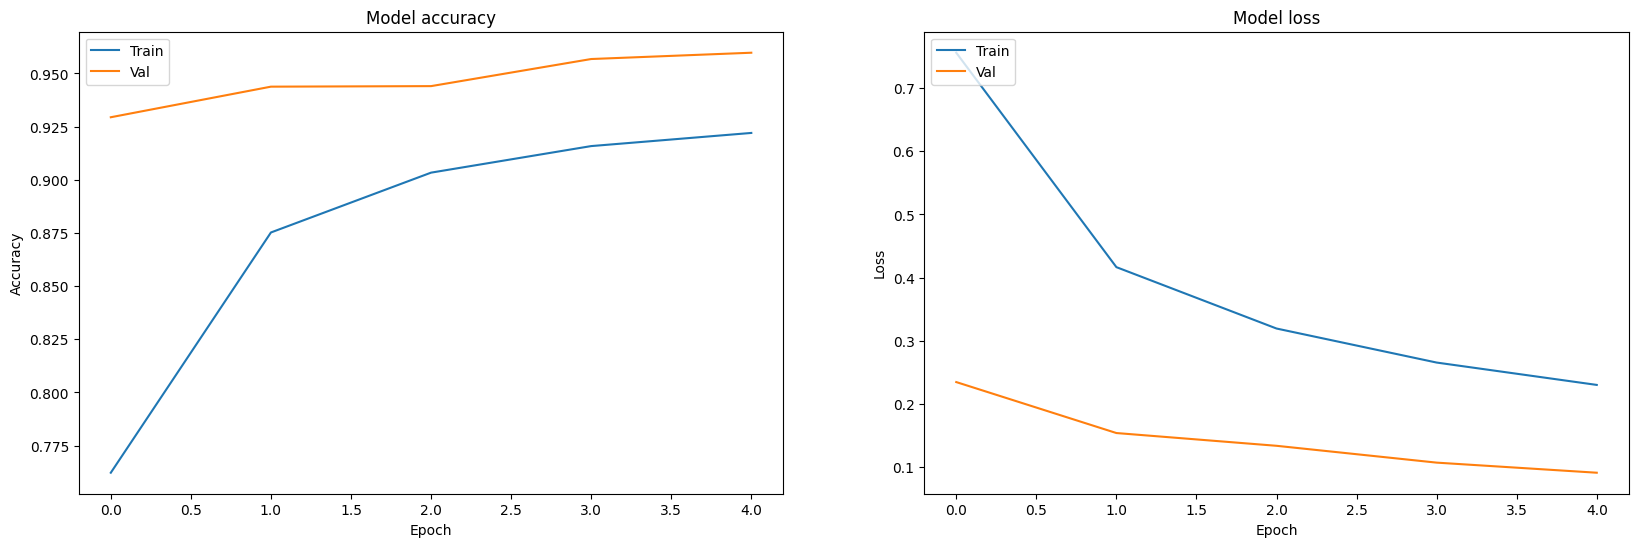

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
# Plot training and validation accuracy and loss in one figure
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('Roberts_Accuracy_Loss.png')
plt.show()

files.download('Roberts_Accuracy_Loss.png')  

In [61]:
result_roberta = model.predict([test_inputs, test_masks])

496/496 [==============================] - 139s 264ms/step


In [62]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

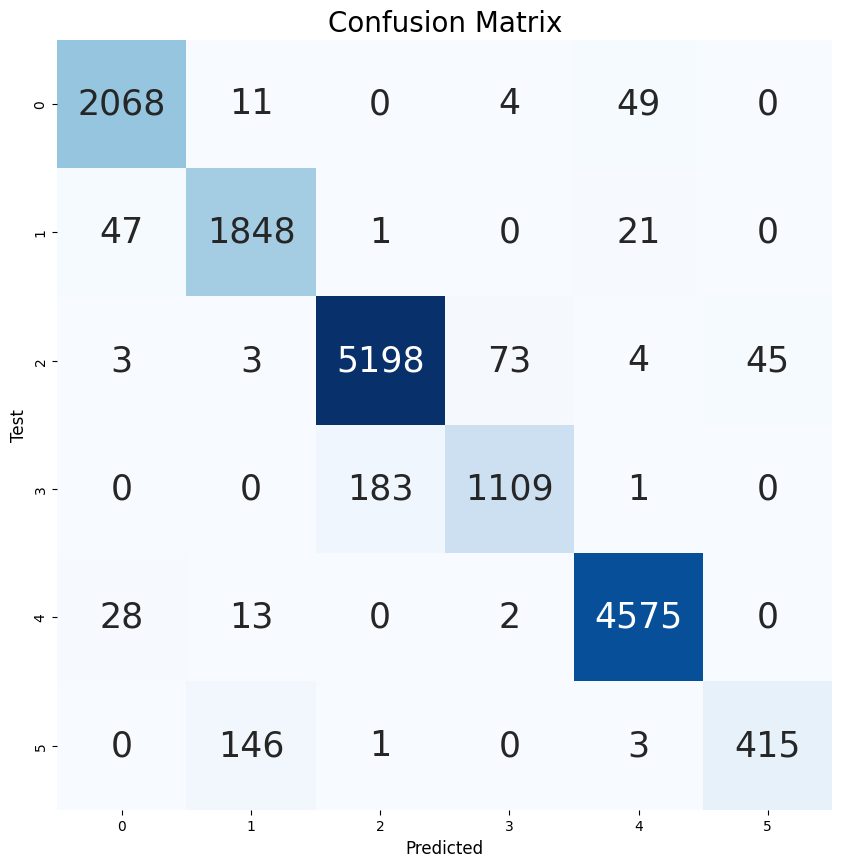

In [63]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'Confusion Matrix')

In [64]:
print('Classification Report:\n\n',classification_report(y_test,y_pred_roberta))

Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2132
           1       0.91      0.96      0.94      1917
           2       0.97      0.98      0.97      5326
           3       0.93      0.86      0.89      1293
           4       0.98      0.99      0.99      4618
           5       0.90      0.73      0.81       565

   micro avg       0.96      0.96      0.96     15851
   macro avg       0.94      0.92      0.93     15851
weighted avg       0.96      0.96      0.96     15851
 samples avg       0.96      0.96      0.96     15851

